# Notebook 04 - Package Comparison

*Martin Vonk - 2023*

This notebooks compares the calculated drought indices to other (Python) packages or time series retrieved from other locations.
Current comparisons include: 
* standard_precip (Python)

## Required packages

In [1]:
import spei as si
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt

## Read Precipitation Data

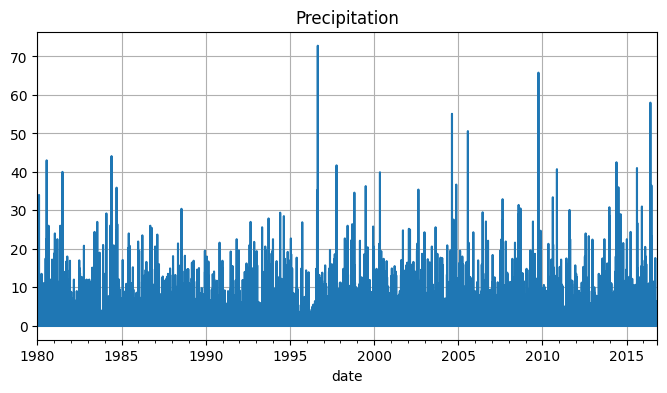

In [2]:
fileurl = "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data"
prec = (
    pd.read_csv(f"{fileurl}/rain_nb1.csv", index_col=0, parse_dates=True)
    .squeeze()
    .multiply(1e3)
)  # to mm
prec.plot(grid=True, title="Precipitation", figsize=(8,4));

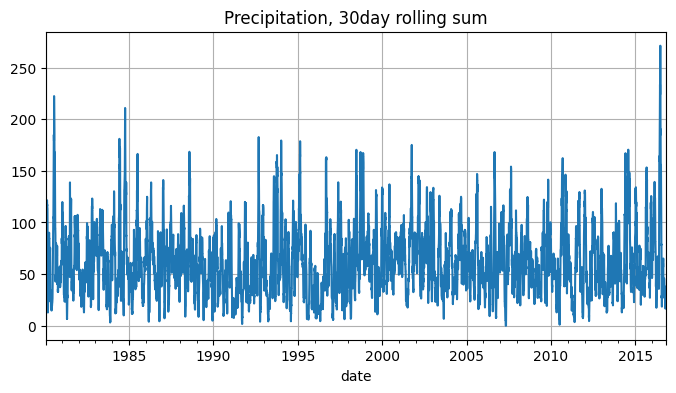

In [3]:
# get rolling sum
prec_rsum = prec.rolling("30D", min_periods=30).sum().dropna()
prec_rsum.plot(grid=True, title="Precipitation, 30day rolling sum", figsize=(8,4));

## Compute Standardized Precipitation Index

### Using SPEI package

In [4]:
spi = si.spi(prec_rsum, dist=scs.gamma, prob_zero=True)
spi # pandas Series

date
1980-01-30   -0.946376
1980-01-31   -0.810205
1980-02-01    0.018504
1980-02-02    0.040376
1980-02-03    0.216153
                ...   
2016-10-27   -0.744963
2016-10-28   -0.744963
2016-10-29   -0.732095
2016-10-30   -0.805841
2016-10-31   -0.850193
Length: 13425, dtype: float64

### Using standard_precip package

In [5]:
from standard_precip import spi as sp_spi
# standard_precip also needs rolling sum dataframe, even though you provide freq="M" and scale = 1
precdf = prec_rsum.to_frame().reset_index().copy()

# initialize spi
standardp_spi_inst = sp_spi.SPI()

# caclulate index with many parameters
standardp_spi = standardp_spi_inst.calculate(
    precdf,
    date_col="date",
    precip_cols="rain",
    freq="M",  
    scale=1, # scale is weird naming choice here because that's the same keyword used for the standard deviation in SciPy
    fit_type="mle",
    dist_type="gam",
)
standardp_spi.index = standardp_spi.loc[:, "date"].values # create datetimeindex because date had to be a column

standardp_spi # pandas DataFrame

,date,rain,rain_calculated_index
1980-01-30,1980-01-30,43.1,-0.946377
1980-01-31,1980-01-31,46.8,-0.810206
1980-02-01,1980-02-01,56.3,0.018504
1980-02-02,1980-02-02,57.0,0.040376
1980-02-03,1980-02-03,62.8,0.216153
...,...,...,...
2016-10-27,2016-10-27,37.5,-0.744964
2016-10-28,2016-10-28,37.5,-0.744964
2016-10-29,2016-10-29,37.8,-0.732096
2016-10-30,2016-10-30,36.1,-0.805842


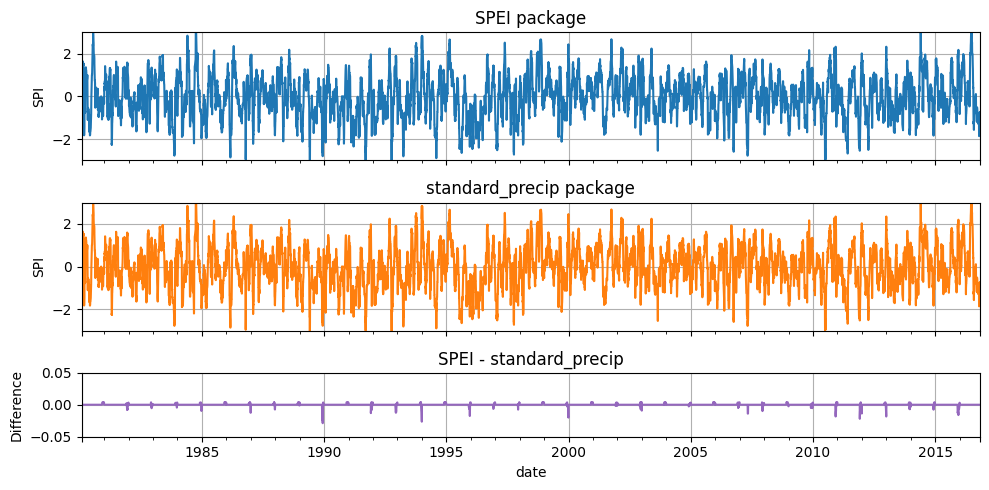

In [6]:
f, ax = plt.subplot_mosaic([["SPEI"],["standard_precip"], ["DIFF"]], figsize=(10,5), sharex=True, height_ratios=[2,2,1])
spi.plot(ax=ax["SPEI"], grid=True)
standardp_spi.loc[:, "rain_calculated_index"].plot(ax=ax["standard_precip"], color="C1", grid=True)
(spi - standardp_spi.loc[:, "rain_calculated_index"]).plot(ax=ax["DIFF"], color="C4", grid=True)
[(ax[x].set_ylim(-3, 3), ax[x].set_title(x + " package"), ax[x].set_ylabel("SPI")) for x in ("SPEI", "standard_precip")]
ax["DIFF"].set_ylim(-0.05, 0.05)
ax["DIFF"].set_title("SPEI - standard_precip")
ax["DIFF"].set_ylabel("Difference")
f.tight_layout()

Difference is relatively small.

The standard_precip package does not explicitely support the Standardized Precipitaion Evaporation Index, as far as I can see. However, the SPI class in standard_precip could probably be used, even though the naming of `precip_cols` is not universal. In general, the standard_precip package needs much more keyword arguments while the SPEI package makes more use of all the nice logic already available in SciPy and Pandas.